## <center>Market ABM<center>

## Historical Returns

We start by looking at historical stock market (SPY) returns from 2006-2021.

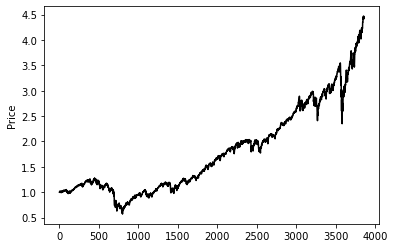

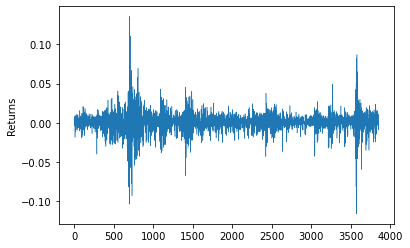

In [1]:
from pylab import *
import numpy as np
import scipy.stats as stats
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

file = 'https://raw.githubusercontent.com/ssie-projects/ssie523-abm-markets/lux-abm/research/SPY2006.csv'

df = pd.read_csv(file)
df['log_adj_close'] = np.log(df['Adj Close'])
r_hist = np.diff(df['log_adj_close'].tolist())

plot(df['Adj Close'] / df['Adj Close'][0], 'k')
ylabel('Price')
show()
    
plot(r_hist, linewidth=0.5)
ylabel('Returns')
show()  

Volatility clustering and kurtosis (fat tails) are evident in plot of returns.

Calculate some summary statistics.

In [2]:
mu = np.mean(r_hist)
sigma = np.std(r_hist)
sigma2 = np.var(r_hist)
skew = stats.skew(r_hist)
kurt = stats.kurtosis(r_hist)

mu_gt = mu
sigma_gt = sigma
sigma2_gt = sigma2
skew_gt = skew
kurt_gt = kurt

print('Ground Truth Stats (daily log returns):')
print('Mean:\t\t\t', mu)
print('Std dev:\t\t', sigma)
print('Variance:\t\t', sigma2)
print('Skew:\t\t\t', skew)
print('Excess kurt:\t\t', kurt)
print()

mu_a = mu * 252
sigma_a = sigma * np.sqrt(252)
sigma2_a = sigma2 * 252

print('Annualized return statistics:')
print('Mean (mu):\t\t', mu_a)
print('Std dev (sigma):\t', sigma_a)
print('Variance:\t\t', sigma2_a)

mu_hist = mu_a               # this is in same unit as mu parameter for GBM and ABM
sigma_hist = sigma_a         # this is in same unit as sigma parameter for GBM

Ground Truth Stats (daily log returns):
Mean:			 0.00038828500211185896
Std dev:		 0.01260968331250487
Variance:		 0.0001590041132416638
Skew:			 -0.39020411671215877
Excess kurt:		 15.06628837558424

Annualized return statistics:
Mean (mu):		 0.09784782053218846
Std dev (sigma):	 0.2001725169370143
Variance:		 0.04006903653689928


## Geometric Brownian Motion (GBM)

The dynamics of the model are described by the following SDE:

$$
dp = \mu p dt + \sigma p dW(t)
$$

where $W(t)$ is simple Brownian motion and is distributed $W(t) \sim N(0, \sigma^2 t)$.

This is simulated using forward Euler as follows:

$$
p_{t+1} = p_t + \mu p_t \Delta t + \sigma p_t \sqrt{\Delta t} Z
$$

where $Z \sim N(0, 1)$.

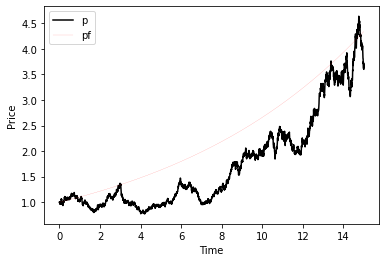

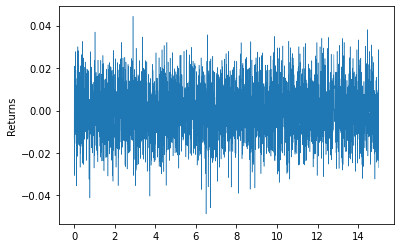

In [3]:
from pylab import *

seed(123)

# "calibrate" model
mu = mu_hist            # taken from historical returns above
sigma = sigma_hist      # taken from historical returns above

T = 15.0
Dt = 1/252   # 252 trading days in year


def initialize():
    global p, t, pvec, tvec, pf, pfvec
    p = 1.0
    t = 0.
    pvec = [p]
    tvec = [t]
    
    # no noise exponential growth, just for comparison
    pf = p
    pfvec = [pf]


def observe():
    global p, t, pvec, tvec, pf, pfvec
    pvec.append(p)
    tvec.append(t)
    pfvec.append(pf)


def update():
    global p, t, pvec, tvec, pf, pfvec
    np = p + mu*p*Dt + sigma*p*sqrt(Dt)*normal()
    t = t + Dt
    npf = pf + mu*pf*Dt
    p, pf = np, npf

initialize()
while t < T:
    update()
    observe()

plot(tvec, pvec, 'k',label='p')
plot(tvec, pfvec, 'r', label='pf', linewidth=0.1)
xlabel('Time')
ylabel('Price')
legend()
show()

plot(tvec[1:], diff(log(pvec)), linewidth=0.5)
ylabel('Returns')
show()


No volatility clustering or kurtosis in plot of returns. Model is inadequate.

Calculate summary statistics.

In [4]:
r_gbm = diff(log(pvec))
    
mu_gbm = np.mean(r_gbm)
sigma_gbm = np.std(r_gbm)
sigma2_gbm = np.var(r_gbm)
skew_gbm = stats.skew(r_gbm)
kurt_gbm = stats.kurtosis(r_gbm)

print('Daily return statistics (GBM):')
print('Mean:\t\t\t', mu_gbm)
print('Std dev:\t\t', sigma_gbm)
print('Variance:\t\t', sigma2_gbm)
print('Skew:\t\t\t', skew_gbm)
print('Excess kurt:\t\t', kurt_gbm)
print()

mu_gbm_a = mu_gbm * 252
sigma_gbm_a = sigma_gbm * np.sqrt(252)
sigma2_gbm_a = sigma2_gbm * 252

print('Annualized return statistics:')
print('Mean (mu):\t\t', mu_gbm_a)         # should match mu_hist on average (i.e. if run many times and averaged)
print('Std dev (sigma):\t', sigma_gbm_a)  # should match mu_hist on average (i.e. if run many times and averaged)
print('Variance:\t\t', sigma2_gbm_a)

Daily return statistics (GBM):
Mean:			 0.0003388903645113953
Std dev:		 0.012374730886741462
Variance:		 0.00015313396451927314
Skew:			 -0.07624935284590766
Excess kurt:		 0.014663748061323645

Annualized return statistics:
Mean (mu):		 0.08540037185687162
Std dev (sigma):	 0.19644276280600625
Variance:		 0.03858975905885683


## Agent Based Model (ABM)

This is an implementation of an expanded version of the ABM model proposed by Alfarano and Lux (2007).

### Basic Model

The basic dynamics of the original model proposed by Alfarano and Lux (2007) are described by the following ODE:

$$
\frac{dp}{dt} = \beta \ [ N_F T_F (p_f - p) + N_C T_C x ] \ p, \qquad x = \frac{N_o - N_p}{N_C}
$$

where $p$ is the market price of the stock, $p_f$ is the intrinsic value of the stock, $N_F$ is the number of fundamentalist traders, and $N_C$ is the number of noise traders. $N_F$ and $N_C$ are chosen beforehand and are fixed in the original paper.

$N_o$ is the number of noise traders who are optimists and $N_p$ is the number of noise traders who are pessimists (where $N_o + N_p = N_c$). $N_o$ and $N_p$ are dynamic and change throughout the simulation (described below). We also add a boundary condition in the implementation to ensure that there is at least one of each type of trader at all times (i.e. $N_o \gt 0$ and $N_p \gt 0$).

$\beta$, $T_F$, and $T_C$ are essentially parameters to tune the model.

Some intuition about the ODE can be seen by rewriting it as follows:

$$
\frac{dp}{dt} = p \ [\beta N_F T_F] (p_f - p) + p \ [\beta N_C T_C] \ x
$$

Note that all values in the brackets are constants. The first expression on the right is just an exponential with a mean reverting term added to it. In words, the model pulls the price back to its fundamental value when it diverges too far. The second expression on the right is also essentially an exponential form, but has noise $x$ added to it. Note that, given the definition of $x$, this noise is always in the interval $x \in (-1, 1)$ and has (stochastic) attractors at -1 and 1, so it can pull the value of the stock above or below the intrinsic value for long periods of time during the simulation.

The simulation initially starts by randomly designating each noise trader an optimist or pessimist. For each timestep, each optimist has a probability $p_o$ of switching to a pessimist and each pessimist has a probability $p_p$ of switching to an optimist, where the switches are Bernoulli and are assigned the following probabilities:
$$
p_o = \nu_1 \Delta t \frac{N_p}{N}
$$

$$
p_p = \nu_1 \Delta t \frac{N_o}{N}
$$

where $\Delta t$ is the simulation timestep. We see from these definitions that when the majority of noise traders are pessimists (optimists), the few remaining optimists (pessimists) will have a high probability of switching to pessimists (optimists), while the pessimists (optimists) will have a low probability of switching to optimists (pessimists). In other words, the system is attracted to the states where the majority of traders are either pessimists or optimists and there is a low probability to switching out of these states.

The simulation is implemented using forward Euler discretization.

### Modifications to the Model

1. The value of $p_f$ is constant in the paper, but the intrinsic value drives the valuation of a stock over time, so we've made this an exponential function in the implementation below:
$$
\frac{dp_f}{dt} = \mu p_f
$$

 This allows the market to grow over time like a real stock market.
 

2. We've added switching between fundamentalist and noise traders based on the following transition probabilities:
 $$
 p_{fc} = \nu_2 \Delta t  e^{-\alpha \rho}
 $$

 $$
 p_{cf} = \nu_2 \Delta t  \left( 1 - e^{-\alpha \rho} \right)
 $$

 where $p_{fc}$ is the probability that a fundamentalist trader switches to a noise trader, $p_{cf}$ is the probability that a noise trader switches to a fundamentalist trader, $\alpha$ is a parameter, and:
 $$
 \rho = \frac{| p_f - p |}{p_f}
 $$

 is the absolute percent deviation from the intrinsic value. Intuitively, $p_{cf}$ grows as the price diverges from the fundamental value, so noise traders increasingly switch to fundamental traders to take advantage of the perceived mispricing. On the other hand, $p_{fc}$ is greatest when there is no deviation from the intrinsic value, in which case there is no perceived advantage to being a fundamental trader, so traders increasingly switch to noise traders.

 On average, we'd like the switching probabilities to be approximately equal so that the asymptotic behavior of the model doesn't tend to all fundamental or all noise traders. We can use this to choose a value for $\alpha$ as follows:

 $$
 \begin{eqnarray*}
 e^{-\alpha \rho} & \approx & 1 - e^{-\alpha \rho} \\
 2 e^{-\alpha \rho} & \approx & 1 \\
 -\alpha \rho & \approx & \ln \frac{1}{2} \\
 \alpha & \approx & - \frac{1}{\rho} \ln \frac{1}{2}
 \end{eqnarray*}
 $$

 For instance, if we assume an approximate 10% percent deviation from the fundamental value over time, we would set $\alpha$ to:
 $$
 \alpha \approx \frac{1}{0.1} \ln \frac{1}{2} \approx 6.9
 $$

In [5]:
from pylab import *
from matplotlib import gridspec

def initialize(init_Tc = None, init_nu1 = None, init_nu2 = None):
    global p, pf, No, Np, Nc, Nf, N, x, t, pvec, pfvec, Novec, Npvec, Ncvec, Nfvec, xvec, traders, tvec
    global Tf, Tc, nu1, nu2, mu, T, Dt, b, alpha
    
    seed(123)

    T = 15.         # simulation length in years
    Dt = 1./252     # 252 trading days in a year

    b = 0.1

    alpha = 6.9

    Nf = 100        # number of fundamentalist traders
    Nc = 100        # number of noise traders
    N = Nf + Nc     # total number of traders

    Tf = 10         # size of trades made by fundamentalist traders
    Tc = 5          # size of trades made by noise traders

    nu1 = 0.7/Dt    # parameter for optimist/pessimist transition probabilities
    nu2 = 0.003/Dt  # parameter for fundamentalist/noise trader transition probabilities

    mu = mu_hist    # annual growth of pf - taken from historical returns above

    if init_Tc is not None:
        Tc = init_Tc
    if init_nu1 is not None:
        nu1 = init_nu1/Dt
    if init_nu2 is not None:
        nu2 = init_nu2/Dt

    pf = 1.0
    p = pf
   
    traders = zeros([1,N])
    for i in range(N):
        if i < Nc:       # noise trader
            traders[0, i] = randint(0, 2)    # 0 (pessimist) or 1 (optimist)
        else:
            traders[0, i] = 2                # fundamentalist

    Np = len(traders[0, traders[0,:] == 0])  # pessimist = 0
    No = len(traders[0, traders[0,:] == 1])  # optimist = 1
    Nf = len(traders[0, traders[0,:] == 2])  # fundamentalist = 2
    Nc = Np + No
    
    x = (No - Np) / Nc
    t = 0.
    
    pvec = [p]
    pfvec = [pf]
    Novec = [No]
    Npvec = [Np]
    Ncvec = [Nc]
    Nfvec = [Nf]
    xvec = [x]
    tvec = [t]

    
def observe():
    global p, pf, No, Np, Nc, Nf, N, x, t, pvec, pfvec, Novec, Npvec, Ncvec, Nfvec, xvec, traders, tvec
    global Tf, Tc, nu1, nu2, mu, T, Dt, b, alpha
    pvec.append(p)
    pfvec.append(pf)
    Novec.append(No)
    Npvec.append(Np)
    Ncvec.append(Nc)
    Nfvec.append(Nf)
    xvec.append(x)
    tvec.append(t)


def update():
    global p, pf, No, Np, Nc, Nf, N, x, t, pvec, pfvec, Novec, Npvec, Ncvec, Nfvec, xvec, traders, tvec
    global Tf, Tc, nu1, nu2, mu, T, Dt, b, alpha

    if 0:
        np = p + p * b * (Nf * Tf * (pf - p) + Nc * Tc * x) * Dt
    else:
        drift = min(p * b * Nf * Tf * Dt, 1.0) * (pf - p) # avoid numerical instability from Euler discretization
        shock = p * b * (Nc * Tc * x) * Dt
        np = p + drift + shock 

    p_o = nu1*Dt*Np/Nc      # probability that optimist switches to pessimist
    p_p = nu1*Dt*No/Nc      # probability that pessimist switches to optimist
    
    optim = binomial(1, 1 - p_o, N)    # 1 - p_o is probability of staying an optimist
    pessim = binomial(1, p_p, N)       # p_p is probability of switching to optimist

    rho = abs(p-pf)/pf
    p_fc = nu2*Dt*exp(-alpha*rho)       # probability that fundamentalist switches to noise
    p_cf = nu2*Dt*(1 - exp(-alpha*rho)) # probability that noise switches to fundamentalist
    funda = binomial(1, p_cf, N)        # p_cf is probability of switching to fundamentalist  
    noise = binomial(1, p_fc, N)        # p_fc is probability of switching to noise

    for i in range(N):
        if traders[0, i] == 2:           # fundamentalist
            pass
            if noise[i] == 1 and Nf > 1:
                traders[0, i] = randint(0, 2)  # switch to noise
                Nf -= 1
        elif funda[i] == 1:              # noise trader switches to fundamentalist
            traders[0, i] = 2;           
        elif traders[0, i] == 1:         # optimist
            traders[0, i] = optim[i]
        else:                            # pessimist
            traders[0, i] = pessim[i]

    nNf = len(traders[0, traders[0,:] == 2])
    nNo = len(traders[0, traders[0,:] == 1])
    nNp = len(traders[0, traders[0,:] == 0])
    nNc = nNp + nNo
    if nNp < 1:      # Np = 0 is an absorbing state, so implement refecting boundary
        nNp = 1
        nNo = Nc - 1
    if nNo < 1:      # No = 0 is an absorbing state, so implement refecting boundary
        nNo = 1
        nNp = Nc - 1
        
    nx = (nNo - nNp) / nNc

    npf = pf + mu*pf*Dt
    
    t = t + Dt
    
    p, pf, No, Np, Nc, Nf, x = np, npf, nNo, nNp, nNc, nNf, nx
    
    observe()

### Parameter sweep

In [6]:
t0 = time.time()

file_name = 'market_abm.csv'
try:
    open(file_name)
    os.remove(file_name)
except:
    pass

fout = open(file_name, 'w')
fout.write('Tc, nu1, nu2, mu, sigma, skew, kurtosis, mean_sq_err\n')

results = []
for init_Tc in (1, 2, 3, 5, 10, 15, 20, 25, 30):
    for init_nu1 in linspace(0.1, 0.9, 9):
        for init_nu2 in linspace(0.001, 0.009, 9):
            initialize(init_Tc, init_nu1, init_nu2)
            while t < T:
                update()
            r = diff(log(pvec))
            mu = np.mean(r)
            sigma = np.std(r)
            sigma2 = np.var(r)
            skew = stats.skew(r)
            kurt = stats.kurtosis(r)

            sq_error_mu = ((mu - mu_gt)/mu_gt)**2
            sq_error_sigma2 = ((sigma2 - sigma2_gt)/sigma2_gt)**2
            sq_error_skew = ((skew - skew_gt)/skew_gt)**2
            sq_error_kurt = ((kurt - kurt_gt)/kurt_gt)**2

            mse = np.mean([10 * abs(sq_error_sigma2), # give more weight to variance
                           abs(sq_error_skew), 
                           abs(sq_error_kurt)])
            
            results_dict = dict()
            
            results_dict['init_Tc'] = init_Tc
            results_dict['init_nu1'] = init_nu1
            results_dict['init_nu2'] = init_nu2
            results_dict['data'] = [r][0]
            results_dict['mu'] = mu
            results_dict['sigma'] = sigma
            results_dict['sigma2'] = sigma2
            results_dict['skew'] = skew
            results_dict['kurt'] = kurt
            results_dict['pct_diff_mu'] = sq_error_mu
            results_dict['pct_diff_sigma2'] = sq_error_sigma2
            results_dict['pct_diff_skew'] = sq_error_skew
            results_dict['pct_diff_kurt'] = sq_error_kurt
            results_dict['average'] = mse
            
            results.append(results_dict)
            
            fout.write('%f, %f, %f, %.12lf, %.12lf, %.12lf, %.12lf, %.12lf\n' % (init_Tc, init_nu1, init_nu2, mu, sigma, skew, kurt, mse))


fout.close()

t1 = time.time()
print('Total time: %.f sec' % (t1-t0))

with open('simulationResults.pkl', 'wb') as f:
    pickle.dump(results, f)

Total time: 601 sec


In [7]:
opt_param_results = results[np.argmin([each['average'] for each in results if ~np.isnan(each['average'])])]
opt_param_results

{'init_Tc': 5,
 'init_nu1': 0.7000000000000001,
 'init_nu2': 0.007,
 'data': array([-0.02004075, -0.01994782, -0.02630465, ...,  0.01554302,
        -0.00616459, -0.01416131]),
 'mu': 0.0004080026140868865,
 'sigma': 0.012926364557714632,
 'sigma2': 0.000167090900678941,
 'skew': -0.24238994558612054,
 'kurt': 2.571304133556634,
 'pct_diff_mu': 0.002578739068830761,
 'pct_diff_sigma2': 0.0025866361166029224,
 'pct_diff_skew': 0.14349885999279285,
 'pct_diff_kurt': 0.68779477768675,
 'average': 0.2857199996151907}

In [8]:
opt_Tc = opt_param_results['init_Tc']
opt_Tc

5

In [9]:
opt_nu1 = opt_param_results['init_nu1']
opt_nu1

0.7000000000000001

In [10]:
opt_nu2 = opt_param_results['init_nu2']
opt_nu2

0.007

### Plots and summary statistics for optimized simulation results

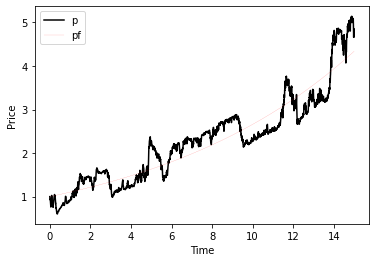

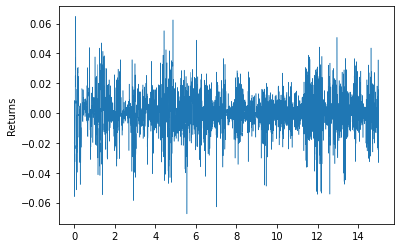

Optimized daily return statistics:
Mean:			 0.0004080026140868865
Std dev:		 0.012926364557714632
Variance:		 0.000167090900678941
Skew:			 -0.24238994558612054
Excess kurt:		 2.571304133556634

Annualized return statistics:
Mean (mu):		 0.1028166587498954
Std dev (sigma):	 0.20519967585523408
Variance:		 0.04210690697109313


In [11]:
initialize(opt_Tc, opt_nu1, opt_nu2)
while t < T:
    update()

plot(tvec, pvec, 'k',label='p')
plot(tvec, pfvec, 'r', label='pf', linewidth=0.1)
xlabel('Time')
ylabel('Price')
legend()
show()

plot(tvec[1:], diff(log(pvec)), linewidth=0.5)
ylabel('Returns')
show()    

r_abm = diff(log(pvec))

mu_abm = np.mean(r_abm)
sigma_abm = np.std(r_abm)
sigma2_abm = np.var(r_abm)
skew_abm = stats.skew(r_abm)
kurt_abm = stats.kurtosis(r_abm)

print('Optimized daily return statistics:')
print('Mean:\t\t\t', mu_abm)
print('Std dev:\t\t', sigma_abm)
print('Variance:\t\t', sigma2_abm)
print('Skew:\t\t\t', skew_abm)
print('Excess kurt:\t\t', kurt_abm)
print()

mu_abm_a = mu_abm * 252                       # this is in same unit as mu parameter for GBM
sigma_abm_a = sigma_abm * np.sqrt(252)        # this is in same unit as sigma parameter for GBM
sigma2_abm_a = sigma2_abm * 252

print('Annualized return statistics:')
print('Mean (mu):\t\t', mu_abm_a)             # should match mu_hist on average (i.e. if run many times and averaged)
print('Std dev (sigma):\t', sigma_abm_a)
print('Variance:\t\t', sigma2_abm_a)


## Plots for paper

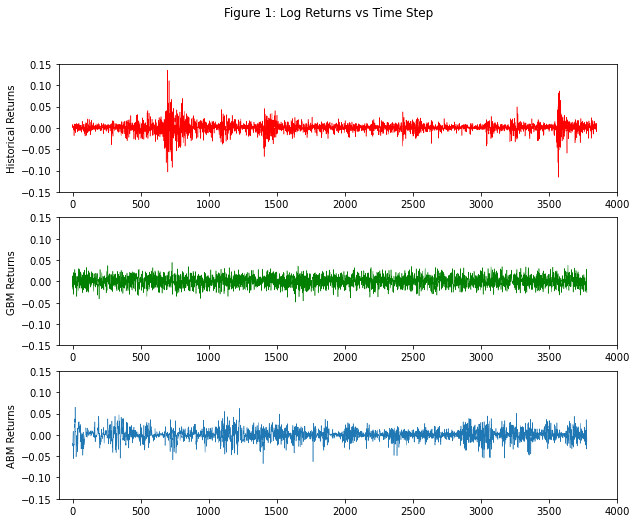

In [12]:
# Plot returns of all three

plt.figure(figsize=[10,8])
plt.subplot(3, 1, 1)

plt.plot(r_hist, linewidth=0.5, color='red', label='A')
plt.ylabel('Historical Returns')
plt.xlim(-100,4000)
plt.ylim(-0.15, 0.15)

plt.subplot(3, 1, 2)
plt.plot(r_gbm, linewidth=0.5, color='green', label='B')
plt.ylabel('GBM Returns')
plt.xlim(-100,4000)
plt.ylim(-0.15, 0.15)

plt.subplot(3, 1, 3)
plt.plot(r_abm, linewidth=0.5, label='C')
plt.ylabel('ABM Returns')
plt.xlim(-100,4000)
plt.ylim(-0.15, 0.15)

plt.suptitle('Figure 1: Log Returns vs Time Step')
plt.savefig('returns.png', dpi=300)

plt.show()

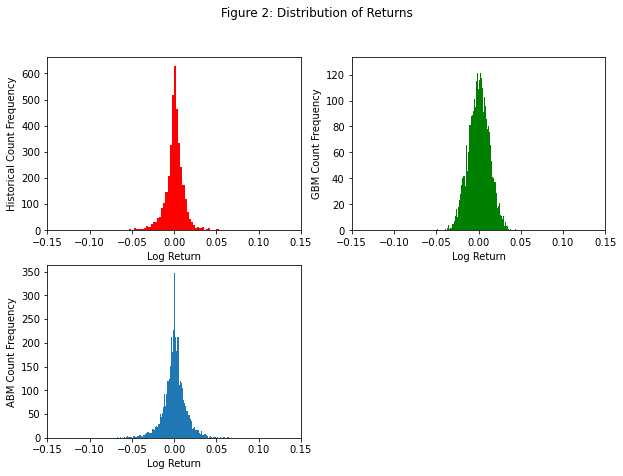

In [13]:
# Plot histogram of all three

plt.figure(figsize=[10,7])
plt.subplot(2, 2, 1)
plt.hist(r_hist, bins=100, color='red')
plt.ylabel('Historical Count Frequency')
plt.xlabel('Log Return')
plt.xlim(-0.15, 0.15)

plt.subplot(2, 2, 2)
plt.hist(r_gbm, bins=100, color='green')
plt.ylabel('GBM Count Frequency')
plt.xlabel('Log Return')
plt.xlim(-0.15, 0.15)

plt.subplot(2, 2, 3)
plt.hist(r_abm, bins=100)
plt.ylabel('ABM Count Frequency')
plt.xlabel('Log Return')
plt.xlim(-0.15, 0.15)

plt.suptitle('Figure 2: Distribution of Returns')
plt.savefig('return_hist.png', dpi=300)

plt.show()

### ABM Visualization


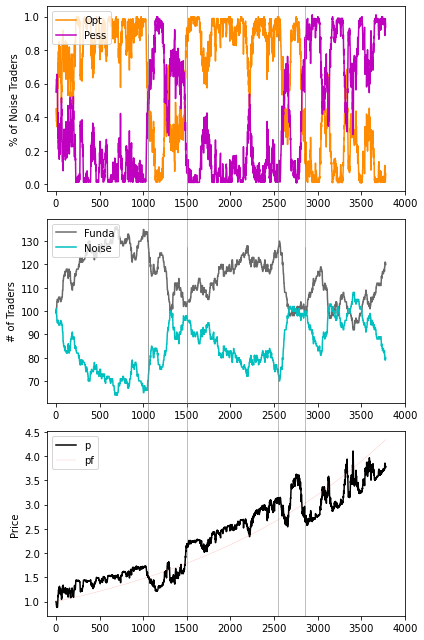

In [14]:
initialize()
while t < T:
    update()

fig = plt.figure(figsize=[6,9])
ax1 = plt.subplot(3, 1, 1)
plot([x/y for x,y in zip(Novec, Ncvec)], 'darkorange', label='Opt')
plot([x/y for x,y in zip(Npvec, Ncvec)], 'm', label='Pess')
ylabel('% of Noise Traders')
plt.xlim(-100,4000)
legend(loc ='upper left')

ax2 = plt.subplot(3, 1, 2)
plot(Nfvec, 'dimgray', label='Funda')
plot(Ncvec, 'c', label='Noise')
ylabel('# of Traders')
plt.xlim(-100,4000)
legend(loc ='upper left')

ax3 = plt.subplot(3, 1, 3)
plot(pvec, 'k',label='p')
plot(pfvec, 'r', label='pf', linewidth=0.1)
ylabel('Price')
plt.xlim(-100,4000)
legend(loc ='upper left')

ax1.axvline(x=1050,ymin=0,ymax=1,c='gray', linewidth=0.5, zorder=0, clip_on=False)
ax2.axvline(x=1050,ymin=0,ymax=2,c='gray', linewidth=0.5, zorder=0, clip_on=False)
ax3.axvline(x=1050,ymin=0,ymax=2,c='gray', linewidth=0.5, zorder=0, clip_on=False)

ax1.axvline(x=1500,ymin=0,ymax=1,c='gray', linewidth=0.5, zorder=0, clip_on=False)
ax2.axvline(x=1500,ymin=0,ymax=2,c='gray', linewidth=0.5, zorder=0, clip_on=False)
ax3.axvline(x=1500,ymin=0,ymax=2,c='gray', linewidth=0.5, zorder=0, clip_on=False)

ax1.axvline(x=2550,ymin=0,ymax=1,c='gray', linewidth=0.5, zorder=0, clip_on=False)
ax2.axvline(x=2550,ymin=0,ymax=2,c='gray', linewidth=0.5, zorder=0, clip_on=False)
ax3.axvline(x=2550,ymin=0,ymax=2,c='gray', linewidth=0.5, zorder=0, clip_on=False)

ax1.axvline(x=2850,ymin=0,ymax=1,c='gray', linewidth=0.5, zorder=0, clip_on=False)
ax2.axvline(x=2850,ymin=0,ymax=2,c='gray', linewidth=0.5, zorder=0, clip_on=False)
ax3.axvline(x=2850,ymin=0,ymax=2,c='gray', linewidth=0.5, zorder=0, clip_on=False)

fig.tight_layout()

plt.savefig('abm_visual.png', dpi=300)

show()

Set run_pycx to True for an animated simulation (you'll need to expand the size of the dialog that pops up to see all the plots). Each individual square on the top represents a trader (magenta/purple for pessimist, orange for optimist, and cyan for fundamentalist). The second bar just aggregates the results to get a quick view of whether the market overall is optimistic or pessimistic. The first time series plots the split between optimists and pessimists. The second plots the total number of fundamentalist traders and noise traders. The third plots the fundamental (intrinsic) value and the simulated market price. The last plots the returns.

In [15]:
run_pycx = False

cmap = mpl.colors.ListedColormap(['m', 'darkorange', 'c', 'w'])
bounds = [0., 0.5, 1.5, 2.5, 3.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

def observe_pycx():
    cla()
    gs = gridspec.GridSpec(6, 1, height_ratios=[4, 1, 10, 10, 10, 10]) 

    ax1 = subplot(gs[0])
    ax1.title.set_text("Indivdual Traders")
    imshow([N//2 * [3], traders[0,0:N//2],traders[0,N//2:N]], cmap = cmap, norm=norm)
    plt.axis('off')
    axis([0, N//2, 0, 3])
    show()
    
    ax2 = subplot(gs[1])
    ax2.title.set_text("Total Pessimists/Optimists/Fundamentalists")
    imshow(sort(traders), cmap = cmap, norm=norm)
    plt.xlabel('Traders')
    plt.axis('off')
    axis([0, N, 0, 1])

    subplot(gs[2])
    plot(tvec, [x/y for x,y in zip(Novec, Ncvec)], 'darkorange', label='Opt')
    plot(tvec, [x/y for x,y in zip(Npvec, Ncvec)], 'm', label='Pess')
    ylabel('% of Noise Traders')
    legend()
    show()

    subplot(gs[3])
    plot(tvec, Nfvec, 'c', label='Funda')
    plot(tvec, Ncvec, 'dimgray', label='Noise')
    ylabel('# of Traders')
    legend()
    show()

    subplot(gs[4])
    plot(tvec, pvec, 'k', label='p')
    plot(tvec, pfvec, 'r', label='pf', linewidth=0.1)
    xlabel('Time')
    ylabel('Price')
    legend()

    subplot(gs[5])
    plot(tvec[1:], diff(log(pvec)), linewidth=0.5)
    ylabel('Returns')

    
if run_pycx:

    import pycxsimulator
    pycxsimulator.GUI(stepSize = 15).start(func=[initialize, observe_pycx, update])
